In [1]:
%load_ext autoreload

%autoreload 2
import time
import pandas
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


from chainer.datasets import tuple_dataset
from chainer.dataset import convert, concat_examples

import numpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# model
多層パーセプトロンです。

In [2]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [6]:
class cnn3layersGAP_class_conv(chainer.Chain):
    """
    cnn3layersGAP_class の畳み込み部
    """

    def __init__(self, n_out=7, gpu_enable=0, seed_id=10,
                 conf_yaml="./Configures/network.yaml",
                 ):
        net_name = "cnn3layersGAP_class"

        super(cnn3layersGAP_class_conv, self).__init__(
            conv1=L.Convolution2D(in_channels=1,
                                  out_channels=cnf_channels[0],
                                  ksize=(self.kernel, 1),
                                  pad=(self.padding, 0), stride=self.stride,
                                  ),
            conv2=L.Convolution2D(in_channels=cnf_channels[0],
                                  out_channels=cnf_channels[1],
                                  ksize=(self.kernel, 1),
                                  pad=(self.padding, 0), stride=self.stride,
                                  ),
            conv3=L.Convolution2D(in_channels=cnf_channels[1],
                                  out_channels=cnf_channels[2],
                                  ksize=(self.kernel, 1),
                                  pad=(self.padding, 0), stride=self.stride,
                                  ),
            fc0=L.Linear(None, n_out),
        )

    def __call__(self, x):
        x = x.reshape(x.shape[0], 1, -1, 1)
        if self.gpu_enable:
            x = chainer.cuda.to_gpu(x)

        h1 = F.max_pooling_2d(self.activation(self.conv1(x)), self.pooling)
        h2 = F.max_pooling_2d(self.activation(self.conv2(h1)), self.pooling)
        h3 = F.local_response_normalization(
            self.activation(self.conv3(h2)))
        h4 = F.mean(h3, axis=(2, -1), keepdims=False)
        ret = self.fc0(x)
        if self.out_all:
            return ret, h1, h2, h3
        else:
            return ret

class cnn3layersGAP_class_ret(chainer.Chain):
    """
    cnn3layersGAP_class の分類部
    """

    def __init__(self, n_out=7, gpu_enable=0, seed_id=10,
#                  conf_yaml="./Configures/network.yaml",
                 ):
        net_name = "cnn3layersGAP_class"
#         with open(conf_yaml, "r") as conf:
#             out = yaml.load(conf)
#             cnf_channels = numpy.array(
#                 out[net_name]["channels"].split(","), dtype=int)
#             cnf_kernel = out[net_name]["kernel"]  # kernel sizeは単一
#             cnf_pooling = out[net_name]["pooling"]  # pooling sizeは単一
#             cnf_slope = out[net_name]["slope"]  # pooling sizeは単一
#             cnf_padding = out[net_name]["padding"]  # pooling sizeは単一
#             cnf_stride = out[net_name]["stride"]  # pooling sizeは単一
#             cnf_dropout = numpy.float32(out[net_name]["dropout"])

        self.out_all = 0
        self.gpu_enable = gpu_enable
        self.kind = net_name
        self.run_id = "id.%s.%s" % (now(fmt="%H%M%S"), self.kind)
#         self.kernel = cnf_kernel
#         self.padding = cnf_padding
#         self.stride = cnf_stride
#         self.pooling = cnf_pooling
#         self.net_strct = out[net_name]
#         self.slope = cnf_slope
#         self.activation = lambda x: F.relu(x)

        super(cnn3layersGAP_class_ret, self).__init__(
            fc0=L.Linear(None, n_out),
        )

    def __call__(self, x):
        if self.gpu_enable:
            x = chainer.cuda.to_gpu(x)

        ret = self.fc0(x)

        return ret

# main

In [147]:
help(L.Classifier)

Help on class Classifier in module chainer.links.model.classifier:

class Classifier(chainer.link.Chain)
 |  A simple classifier model.
 |  
 |  This is an example of chain that wraps another chain. It computes the
 |  loss and accuracy based on a given input/label pair.
 |  
 |  Args:
 |      predictor (~chainer.Link): Predictor network.
 |      lossfun (function): Loss function.
 |      accfun (function): Function that computes accuracy.
 |      label_key (int or str): Key to specify label variable from arguments.
 |          When it is ``int``, a variable in positional arguments is used.
 |          And when it is ``str``, a variable in keyword arguments is used.
 |  
 |  Attributes:
 |      predictor (~chainer.Link): Predictor network.
 |      lossfun (function): Loss function.
 |      accfun (function): Function that computes accuracy.
 |      y (~chainer.Variable): Prediction for the last minibatch.
 |      loss (~chainer.Variable): Loss value for the last minibatch.
 |      accu

In [44]:
net = MLP(1000, 10)
model = L.Classifier(net)



In [45]:
# Setup an optimizer
optimizer = chainer.optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08)
optimizer.setup(model)
# help(chainer.optimizers.adam)


# 解析データの準備

In [46]:
train, test = chainer.datasets.get_mnist()
train_iter = chainer.iterators.SerialIterator(train, 10)
test_iter = chainer.iterators.SerialIterator(test, 10, repeat=False, shuffle=False)




In [47]:
# train_iter.reset()
# tmp = train_iter.next()[0]

# print len(tmp[0])
# %matplotlib inline
# from pylab import *
# imshow(tmp[0].reshape(28, 28))
# print tmp[1]

In [48]:
epoch = 100
train_iter.reset()
test_iter.reset()

# Set up a trainer
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (5, 'epoch'), out="./Result20180612")

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=0))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
# if args_plot and extensions.PlotReport.available():
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
# trainer.extend(extensions.ProgressBar())

# chainer.serializers.load_npz("", trainer)

In [49]:
#     if args.resume:
#         # Resume from a snapshot
#         chainer.serializers.load_npz(args.resume, trainer)

    # Run the training
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.196587    0.114525              0.940716       0.965201                  16.9651       
2           0.103239    0.0897975             0.97037        0.974501                  33.8391       
3           0.0772711   0.104126              0.977939       0.9731                    50.746        
4           0.0648686   0.0921546             0.981707       0.978101                  67.4298       
5           0.0536131   0.098577              0.985492       0.979201                  84.1679       


# 答え合わせ

784


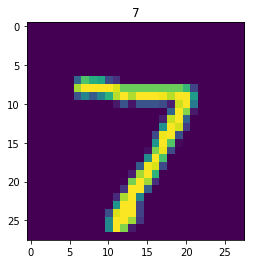

In [50]:
test_iter.reset()
tmp = test_iter.next()[0]

%matplotlib inline
from pylab import *
imshow(tmp[0].reshape(28, -1))
title(tmp[1])

In [62]:
net.to_cpu()
print(net(tmp[0].reshape(1, 784)).data)
print(numpy.argmax(net(tmp[0].reshape(1, 784)).data))

[[-39.32841873 -21.82093239 -20.63142014 -21.871521   -17.40114021
  -28.45369339 -45.95240021  14.37878418 -25.31378555  -6.57826471]]
7


# 混用率データを10クラスに分類

In [109]:
# network
del net
net = MLP(5000, 10)
model = L.Classifier(net)

# optimizer
optimizer = chainer.optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08)
optimizer.setup(model)

In [64]:
import pandas
import numpy

In [65]:
xls = pandas.read_excel("/home/fiber_classifier/Desktop/FY2017to2018_twada/00_Data/MixtureRate/CP.xls")

In [68]:
arr = xls.as_matrix()
print arr


data = arr[:-1]
ref = arr[-1]
data.shape

[[  1.649956   1.744934   1.477748 ...,   1.84188    2.12889    1.539038]
 [  1.668363   1.765425   1.495271 ...,   1.855462   2.129624   1.561538]
 [  1.683173   1.783925   1.509817 ...,   1.866887   2.131713   1.58089 ]
 ..., 
 [  1.243391   1.361463   1.039149 ...,   1.437117   1.382287   1.190141]
 [  1.244529   1.362442   1.040034 ...,   1.438557   1.38381    1.191275]
 [ 76.7       65.8       79.6      ...,  65.7        0.4       83.8     ]]


(1713, 127)

In [69]:
list_ref = []

for v in ref:
    list_ref.append(round(v/10))

In [71]:
label = numpy.array(list_ref, dtype=numpy.int)
len(label)

127

In [125]:
# train, test = chainer.datasets.get_mnist()
# train_iter = chainer.iterators.SerialIterator(train, 10)
# test_iter = chainer.iterators.SerialIterator(test, 10, repeat=False, shuffle=False)

x_train, y_train = data[:,:100].astype(numpy.float32), label[:100]
x_test, y_test = data[:,100:].astype(numpy.float32), label[100:]

train = tuple_dataset.TupleDataset(x_train.reshape(-1, 1713), y_train)
test = tuple_dataset.TupleDataset(x_test.reshape(-1, 1713), y_test)


train_iter = chainer.iterators.SerialIterator(train, 10)
test_iter = chainer.iterators.SerialIterator(test, 28, repeat=False, shuffle=False)

In [110]:
epoch = 100
train_iter.reset()
test_iter.reset()

# Set up a trainer
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (epoch, 'epoch'), out="./Result20180612")

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=0))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
# if args_plot and extensions.PlotReport.available():
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
# trainer.extend(extensions.ProgressBar())

# chainer.serializers.load_npz("", trainer)


trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           14.0452     1.95154               0.17           0.261905                  0.0895581     
2           2.10019     1.97807               0.22           0.0333333                 0.788967      
3           2.09018     1.99784               0.24           0.490476                  1.03541       
4           2.00137     1.99884               0.26           0.0333333                 1.31256       
5           2.00594     1.99555               0.24           0.0333333                 1.56139       
6           2.00296     1.93403               0.19           0.490476                  1.82197       
7           1.96131     1.89336               0.2            0.409524                  2.07515       
8           1.98409     1.95074               0.22           0.490476                  2.38262       
9           1.98505     1.91316               0.26           0.490476               

79          1.87331     1.95368               0.26           0.42381                   22.2133       
80          1.86276     1.98425               0.25           0.42381                   22.4845       
81          1.8362      1.87986               0.3            0.490476                  22.7558       
82          1.87903     1.87811               0.26           0.490476                  23.0271       
83          1.83179     1.95581               0.3            0.490476                  23.3116       
84          1.88073     2.04042               0.27           0.128571                  23.5643       
85          1.93385     1.92499               0.3            0.209524                  23.8185       
86          1.8214      1.95565               0.29           0.457143                  24.0741       
87          1.83454     2.04718               0.3            0.0809524                 24.3359       
88          1.87697     1.9033                0.3            0.490476             

In [113]:
test_iter.reset()
tmp = test_iter.next()[0]

net.to_cpu()
print(net(tmp[0].reshape(1, 1713)).data)
print(numpy.argmax(net(tmp[0].reshape(1, 1713)).data))

[[-3.58276725 -3.17322063 -0.67134076 -1.46576715  0.4535749  -0.02769754
   1.83521616  1.56165397  1.66143465 -4.01503372]]
6


In [133]:
test_iter.reset()

test_batch = test_iter.next()
test_spc, test_ref = concat_examples(test_batch)  # Test Dataset
for i in range(27):
    ref = test_ref[i]
    pred = numpy.argmax(net(test_spc[i].reshape(1, 1713)).data)
    print("Ref: %d, Pred: %d %s" % (ref, pred, ref == pred))

Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 8 True
Ref: 2, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 8 True
Ref: 7, Pred: 6 False
Ref: 9, Pred: 8 False
Ref: 9, Pred: 8 False
Ref: 4, Pred: 8 False
Ref: 2, Pred: 8 False
Ref: 7, Pred: 8 False
Ref: 7, Pred: 8 False
Ref: 6, Pred: 8 False
Ref: 8, Pred: 8 True
Ref: 7, Pred: 8 False
Ref: 7, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 8 True
Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 7, Pred: 6 False
Ref: 7, Pred: 8 False
Ref: 0, Pred: 8 False
Ref: 8, Pred: 8 True


In [146]:

numpy.histogram(a=arr[-1], bins=10)

(array([ 3,  2, 12,  6,  7,  7, 21, 26, 23, 20]),
 array([  0.4 ,   9.52,  18.64,  27.76,  36.88,  46.  ,  55.12,  64.24,
         73.36,  82.48,  91.6 ]))

In [5]:
import glob


In [6]:
import pandas
# xls = pandas.read_csv(pe_list[0], skiprows=1, delimiter=" ", header=None)


In [8]:
data = xls.as_matrix()[:,1]  # numpy.array 
data

array([ 0.431214,  0.856681,  0.036824, ...,  0.040207,  0.04006 ,
        0.039846])

In [9]:
xls0 = pandas.read_csv(pe_list[0], skiprows=1, delimiter=" ", header=None)
data0 = xls0.as_matrix()[:,1]  # numpy.array 
xls1 = pandas.read_csv(pe_list[1], skiprows=1, delimiter=" ", header=None)
data1 = xls1.as_matrix()[:,1]  # numpy.array 



In [10]:
sum_data = numpy.vstack((data0, data1))


In [67]:
hddr = list()
print(hddr)

['ポ', 'リ', 'エ', 'ス', 'テ', 'ル', '-', '0', '3', '.', 't', 'x', 't']


# データ作成

In [134]:
pandas.read_csv(c1_list[0], skiprows=4, delimiter="\t", header=None)

,0,1
0,399.339265,0.097489
1,400.765476,0.102860
2,402.191688,0.097957
3,403.617900,0.092727
4,405.044111,0.084772
5,406.470323,0.079965
6,407.896535,0.083776
7,409.322746,0.083452
8,410.748958,0.078144
9,412.175170,0.078473


In [3]:
import os
import glob
import numpy


co_list = sorted(glob.glob("/home/fiber_classifier/Desktop/oono/cotton-*"))
c1_list = sorted(glob.glob("/home/fiber_classifier/Desktop/oono/C1P9-*"))







for i, fname in enumerate(co_list):
#     print(r"%d: %s" % (i, fname))
    xls = pandas.read_csv(fname, skiprows=4, delimiter="\t", header=None)
    name = os.path.split(fname)[1].split(".")[0] # add:: 2018.07.23

    if i == 0:       
        arr = xls.as_matrix()[:,1]  # numpy.array
        hddr = name # add:: 2018.07.23
    else:
        arr = numpy.vstack((arr, xls.as_matrix()[:,1]))
        hddr = numpy.hstack((hddr, name)) # add:: 2018.07.23

# ポリエステルの配列


In [4]:
arr.shape

(7, 2526)

In [29]:
co_list

['/home/fiber_classifier/Desktop/oono/cotton-1.txt',
 '/home/fiber_classifier/Desktop/oono/cotton-2.txt',
 '/home/fiber_classifier/Desktop/oono/cotton-3.txt',
 '/home/fiber_classifier/Desktop/oono/cotton-4.txt',
 '/home/fiber_classifier/Desktop/oono/cotton-5.txt',
 '/home/fiber_classifier/Desktop/oono/cotton-6.txt',
 '/home/fiber_classifier/Desktop/oono/cotton-7.txt']

In [5]:
print(co_list[0])
print((os.path.split(co_list[0])[1]).split(".")[0])

/home/fiber_classifier/Desktop/oono/cotton-1.txt
cotton-1


In [6]:
print(arr.shape)
print(hddr)

# df = pandas.DataFrame()

(7, 2526)
['cotton-1' 'cotton-2' 'cotton-3' 'cotton-4' 'cotton-5' 'cotton-6'
 'cotton-7']


In [2]:
# ポリエステルの配列に綿のデータを結合

for list_ in (c2_list, c3_list, c4_list, c5_list, c6_list, c7_list, c8_list, c9_list, po_list, c1_list):
    for i, fname in enumerate(list_):
        xls = pandas.read_csv(fname, skiprows=4, delimiter="\t", header=None)
        arr = numpy.vstack((arr, xls.as_matrix()[:,1]))
        hddr = numpy.hstack((hddr, os.path.split(fname)[1].split(".")[0])) # add:: 2018.07.23
    print(arr.shape)

(20, 2526)
(30, 2526)
(40, 2526)
(50, 2526)
(60, 2526)
(70, 2526)
(80, 2526)
(90, 2526)
(100, 2526)
(110, 2526)


In [7]:
# ポリエステルと綿の配列に麻のデータを結合

for i, fname in enumerate(c1_list):
    xls = pandas.read_csv(fname, skiprows=4, delimiter="\t", header=None)
    arr = numpy.vstack((arr, xls.as_matrix()[:,1]))
    hddr = numpy.hstack((hddr, os.path.split(fname)[1].split(".")[0])) # add:: 2018.07.23


In [76]:
# ポリエステルと綿と麻の配列に羊毛のデータを結合

for i, fname in enumerate(wo_list):
    xls = pandas.read_csv(fname, skiprows=1, delimiter=" ", header=None)
    arr = numpy.vstack((arr, xls.as_matrix()[:,1]))
    hddr = numpy.hstack((hddr, os.path.split(fname)[1].split(".")[0])) # add:: 2018.07.23


In [125]:
print "Hello"

print("Hello")

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-125-3732ca40af64>, line 1)

In [19]:
# numpy.vstack((arr.T, label)).T.shape
numpy.hstack((wl.astype(numpy.str), "*c"))

array(['399.339265', '400.765476', '402.191688', ...,
       '4000.5237049999996', '*c', '*c'], dtype='<U32')

In [20]:
hddr, hddr.shape

(array(['cotton-1', 'cotton-2', 'cotton-3', 'cotton-4', 'cotton-5',
        'cotton-6', 'cotton-7', 'C1P9-1', 'C1P9-2', 'C1P9-3', 'C1P9-4',
        'C1P9-5', 'C1P9-6', 'C1P9-7'], dtype='<U8'), (14,))

In [3]:
# ラベルの作成
# 0: ポリエステル, 1:綿, 2: 麻 , 3:羊毛

label = numpy.hstack((numpy.zeros(10), numpy.ones(10), numpy.ones(10)*2, numpy.ones(10)*3, numpy.ones(10)*4, 
                      numpy.ones(10)*5, numpy.ones(10)*6, numpy.ones(10)*7, numpy.ones(10)*8,
                      numpy.ones(10)*9, numpy.ones(10)*10)).astype(numpy.int32)
label, label.shape

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10], dtype=int32), (110,))

In [16]:
label = numpy.hstack((numpy.zeros(10), numpy.ones(10))).astype(numpy.int32)
label, label.shape

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=int32), (20,))

In [32]:
print(numpy.hstack((arr.T, label)).shape)
print(hddr.shape)
print(wl.shape)

ValueError: all the input arrays must have same number of dimensions

In [17]:
wl = pandas.read_csv(co_list[0], skiprows=4, delimiter="\t", header=None).as_matrix()[:,0]
wl = numpy.hstack((wl.astype(numpy.str), "*c"))


In [33]:
wl = pandas.read_csv(c1_list[0], skiprows=4, delimiter="\t", header=None).as_matrix()[:,0]
wl = numpy.hstack((wl.astype(numpy.str), "*c"))
wl

array(['399.339265', '400.765476', '402.191688', ...,
       '3999.0974929999998', '4000.5237049999996', '*c'], dtype='<U32')

In [28]:
import pandas
# pandas.DataFrame 型
df = pandas.DataFrame(data=numpy.vstack((arr.T, label)),
                      columns=hddr,
                      index=wl)
df.to_excel("./cp0802.xls")

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [17]:
df

NameError: name 'df' is not defined

In [26]:
# 確認
arr = arr.astype(numpy.float32)  # float64 ==> float32
print(arr.shape)

(14, 2526)


In [ ]:
xls_read = pandas.read_excel("./cp0724.xlsx")

In [13]:
arr = xls_read.as_matrix()[:-1].astype(numpy.float32)
label = xls_read.as_matrix()[-1].astype(numpy.int32)

NameError: name 'xls_read' is not defined

In [56]:
data

NameError: name 'data' is not defined

In [91]:
label

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11], dtype=int32)

# ネットワークの定義など

In [5]:
%load_ext autoreload

%autoreload 2
import time
import pandas
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


from chainer.datasets import tuple_dataset
from chainer.dataset import convert, concat_examples

import numpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# 解析データの準備
id_train = numpy.random.choice(numpy.arange(len(label)), size=84, replace=0)
id_test = numpy.delete(numpy.arange(len(label)), id_train)


train = tuple_dataset.TupleDataset(arr[id_train], label[id_train].T)
train_iter = chainer.iterators.SerialIterator(train, 33)

test = tuple_dataset.TupleDataset(arr[id_test], label[id_test].T)
test_iter = chainer.iterators.SerialIterator(test, 33, repeat=False, shuffle=False)

In [7]:
class MLP(chainer.Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)# n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [8]:
# net = chainer.Sequential(
#     L.Linear(None, n_units),
#     F.relu,
#     L.Linear(None, 1000),
#     F.relu,
#     L.Linear(1000, 3),
# )

In [10]:
net = MLP(1000, 11)
model = L.Classifier(net)




In [11]:
print(net)

In [12]:
# Setup an optimizer
# optimizer = chainer.optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08)
optimizer = chainer.optimizers.SGD()
optimizer.setup(model)
# help(chainer.optimizers.adam)


In [13]:
numpy.random.choice(numpy.arange(60), size=20, replace=0)

array([12, 57, 59, 18, 41,  1, 53, 36, 55, 13, 56, 20, 10, 24, 50,  9, 29,
       31, 32, 15])

In [14]:
epoch = 5000
train_iter.reset()
# test_iter.reset()

# Set up a trainer
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (epoch, 'epoch'), out="./Result2018_oono/%s" % time.strftime("%Y%m%d_%H%M%S"))

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=0))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
# if args_plot and extensions.PlotReport.available():
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
# trainer.extend(extensions.ProgressBar())

# chainer.serializers.load_npz("", trainer)

In [ ]:
trainer.run()



epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           2.40644     2.38917               0.0808081      0.115385                  0.481825      
2           2.39729     2.3882                0.0909091      0.115385                  0.718856      
3           2.39825     2.38748               0.0909091      0.115385                  0.917957      
4           2.39178     2.38645               0.0808081      0.192308                  1.13834       
5           2.38969     2.38567               0.166667       0.153846                  1.34044       
6           2.38632     2.38505               0.131313       0.230769                  1.54664       
7           2.38653     2.38398               0.151515       0.230769                  1.74185       
8           2.38014     2.38273               0.171717       0.230769                  1.97505       
9           2.37671     2.38235               0.151515       0.230769               

79          2.20952     2.32032               0.282828       0.115385                  17.107        
80          2.22719     2.31884               0.272727       0.115385                  17.3156       
81          2.23126     2.31588               0.272727       0.115385                  17.5264       
82          2.18846     2.31559               0.363636       0.115385                  17.7326       
83          2.19346     2.31373               0.323232       0.115385                  17.9474       
84          2.22234     2.3117                0.287879       0.115385                  18.1362       
85          2.17981     2.31087               0.343434       0.115385                  18.3287       
86          2.22207     2.30877               0.242424       0.115385                  18.5153       
87          2.19649     2.30638               0.30303        0.115385                  18.7128       
88          2.18965     2.30475               0.30303        0.115385             

158         1.95251     2.11072               0.262626       0.153846                  33.6559       
159         1.85504     2.11015               0.409091       0.153846                  33.8677       
160         1.93789     2.10491               0.30303        0.153846                  34.0862       
161         1.91657     2.10375               0.333333       0.153846                  34.2988       
162         1.91628     2.09751               0.282828       0.153846                  34.5152       
163         1.89979     2.09686               0.363636       0.153846                  34.7286       
164         1.9356      2.09229               0.343434       0.153846                  35.1969       
165         1.88362     2.09052               0.318182       0.153846                  35.4102       
166         1.88727     2.08884               0.333333       0.153846                  35.6189       
167         1.96235     2.08103               0.30303        0.153846             

237         1.63105     1.87062               0.393939       0.192308                  50.9132       
238         1.71245     1.86513               0.30303        0.192308                  51.1201       
239         1.66323     1.86164               0.363636       0.192308                  51.3329       
240         1.68012     1.86192               0.409091       0.192308                  51.5439       
241         1.64169     1.85837               0.383838       0.192308                  51.7578       
242         1.68935     1.85575               0.333333       0.192308                  51.969        
243         1.66401     1.85418               0.383838       0.192308                  52.1848       
244         1.66974     1.84887               0.363636       0.192308                  52.3994       
245         1.64873     1.84814               0.393939       0.192308                  52.6106       
246         1.63028     1.84437               0.363636       0.192308             

316         1.48813     1.6776                0.535354       0.269231                  67.7344       
317         1.48345     1.67582               0.545455       0.307692                  67.9466       
318         1.48091     1.66848               0.494949       0.307692                  68.1744       
319         1.4751      1.66813               0.545455       0.346154                  68.3857       
320         1.42485     1.66942               0.545455       0.307692                  68.5982       
321         1.53448     1.66461               0.494949       0.423077                  68.8149       
322         1.4361      1.6618                0.530303       0.346154                  69.0266       
323         1.51519     1.66144               0.525253       0.384615                  69.7568       
324         1.45879     1.65596               0.530303       0.346154                  69.967        
325         1.47466     1.6468                0.454545       0.384615             

395         1.30977     1.52879               0.636364       0.423077                  85.7137       
396         1.37644     1.52632               0.560606       0.423077                  85.9441       
397         1.34385     1.51766               0.59596        0.423077                  86.1773       
398         1.36143     1.51909               0.565657       0.423077                  86.4109       
399         1.29225     1.52075               0.636364       0.423077                  87.29         
400         1.36168     1.51777               0.59596        0.423077                  87.5231       
401         1.29716     1.51187               0.636364       0.423077                  87.7522       
402         1.32626     1.52257               0.606061       0.423077                  87.9823       
403         1.30074     1.51072               0.621212       0.423077                  88.21         
404         1.34114     1.51386               0.59596        0.423077             

474         1.21773     1.4072                0.626263       0.461538                  103.476       
475         1.25813     1.39557               0.575758       0.461538                  103.69        
476         1.12735     1.41672               0.69697        0.461538                  103.904       
477         1.23319     1.41367               0.606061       0.423077                  104.123       
478         1.23199     1.40606               0.590909       0.461538                  104.342       
479         1.21433     1.40984               0.626263       0.423077                  104.562       
480         1.24066     1.40104               0.590909       0.461538                  104.779       
481         1.18323     1.40843               0.646465       0.423077                  105           
482         1.22259     1.40197               0.621212       0.461538                  105.219       
483         1.23266     1.39167               0.59596        0.461538             

553         1.19601     1.31864               0.560606       0.461538                  122.173       
554         1.1632      1.3097                0.616162       0.461538                  122.394       
555         1.1115      1.32587               0.621212       0.423077                  122.614       
556         1.09693     1.33039               0.646465       0.461538                  122.842       
557         1.15984     1.31981               0.590909       0.461538                  123.069       
558         1.15078     1.31737               0.636364       0.461538                  123.311       
559         1.12214     1.30648               0.575758       0.5                       123.546       
560         1.11136     1.31421               0.646465       0.461538                  123.796       
561         1.12595     1.31149               0.651515       0.5                       124.04        
562         1.11755     1.31166               0.646465       0.423077             

632         1.09736     1.24572               0.621212       0.5                       141.737       
633         0.998703    1.26494               0.666667       0.423077                  141.971       
634         1.13539     1.2357                0.590909       0.461538                  142.205       
635         1.03658     1.22621               0.646465       0.5                       142.438       
636         1.08533     1.23907               0.621212       0.461538                  142.666       
637         1.01516     1.24754               0.646465       0.461538                  142.899       
638         1.10056     1.2343                0.606061       0.5                       143.127       
639         1.07196     1.22798               0.616162       0.5                       143.359       
640         1.05459     1.22896               0.636364       0.5                       143.59        
641         1.042       1.236                 0.651515       0.461538             

711         0.950341    1.19902               0.666667       0.423077                  160.404       
712         1.01005     1.19211               0.636364       0.5                       160.645       
713         0.965095    1.18287               0.651515       0.5                       160.883       
714         0.990279    1.19519               0.646465       0.5                       161.125       
715         0.987011    1.17476               0.621212       0.5                       161.363       
716         1.00511     1.16748               0.646465       0.461538                  161.609       
717         0.977027    1.15611               0.646465       0.5                       161.85        
718         0.997314    1.19523               0.651515       0.461538                  162.087       
719         0.947121    1.1905                0.636364       0.423077                  162.333       
720         1.08346     1.17766               0.606061       0.461538             

790         0.946236    1.12748               0.636364       0.5                       181.001       
791         0.932489    1.12712               0.656566       0.461538                  181.253       
792         0.964368    1.12796               0.636364       0.538462                  181.499       
793         0.929562    1.13995               0.656566       0.461538                  181.75        
794         0.976941    1.09967               0.606061       0.5                       182.001       
795         0.933397    1.11433               0.666667       0.615385                  182.25        
796         0.845182    1.1524                0.737374       0.5                       182.501       
797         1.04971     1.12297               0.560606       0.461538                  182.747       
798         0.923445    1.11144               0.626263       0.5                       183           
799         0.923304    1.14368               0.69697        0.5                  

869         0.918866    1.09026               0.636364       0.538462                  199.858       
870         0.881808    1.09152               0.646465       0.5                       200.088       
871         0.894094    1.11205               0.656566       0.5                       200.32        
872         0.975607    1.06818               0.666667       0.653846                  200.551       
873         0.847918    1.07604               0.686869       0.576923                  200.789       
874         0.946025    1.09893               0.651515       0.538462                  201.02        
875         0.91579     1.0927                0.646465       0.5                       201.253       
876         0.852824    1.08115               0.69697        0.538462                  201.484       
877         0.91658     1.09937               0.646465       0.5                       201.718       
878         0.872862    1.08045               0.651515       0.538462             

948         0.855713    1.06443               0.666667       0.5                       219.718       
949         0.835917    1.06863               0.69697        0.538462                  219.945       
950         0.869096    1.06261               0.636364       0.538462                  220.175       
951         0.891296    1.0435                0.636364       0.538462                  220.404       
952         0.898309    1.04062               0.626263       0.615385                  220.637       
953         0.816613    1.0663                0.712121       0.5                       220.868       
954         0.890853    1.03431               0.636364       0.653846                  221.104       
955         0.815654    1.05978               0.69697        0.461538                  221.341       
956         0.858432    1.07245               0.656566       0.5                       221.577       
957         0.86922     1.06442               0.681818       0.576923             

1027        0.836245    1.02878               0.666667       0.538462                  238.769       
1028        0.829006    1.04041               0.712121       0.5                       239.012       
1029        0.846099    1.05011               0.646465       0.5                       239.261       
1030        0.769749    1.03091               0.651515       0.576923                  239.502       
1031        0.852587    1.04633               0.656566       0.538462                  239.741       
1032        0.852689    1.03529               0.621212       0.615385                  239.982       
1033        0.849485    1.02827               0.676768       0.538462                  240.224       
1034        0.803458    1.03651               0.681818       0.576923                  240.466       
1035        0.816547    1.03771               0.676768       0.576923                  240.711       
1036        0.861576    0.989193              0.626263       0.576923             

1106        0.781697    1.01406               0.686869       0.576923                  258.176       
1107        0.819243    1.04428               0.636364       0.576923                  258.424       
1108        0.819061    1.0621                0.686869       0.5                       258.671       
1109        0.812026    1.00045               0.621212       0.615385                  258.909       
1110        0.822396    1.01685               0.656566       0.5                       259.158       
1111        0.775154    0.994609              0.69697        0.615385                  259.395       
1112        0.809574    1.06742               0.686869       0.5                       259.635       
1113        0.809267    0.999197              0.626263       0.576923                  259.881       
1114        0.803839    1.0232                0.712121       0.615385                  260.127       
1115        0.83001     1.05306               0.656566       0.538462             

1185        0.770857    1.01245               0.656566       0.576923                  280.664       
1186        0.76614     0.992835              0.69697        0.653846                  280.935       
1187        0.781038    0.973768              0.656566       0.653846                  281.198       
1188        0.830021    1.00168               0.636364       0.576923                  281.451       
1189        0.806391    0.99108               0.636364       0.576923                  281.712       
1190        0.809727    0.988009              0.666667       0.653846                  281.962       
1191        0.7832      0.94714               0.651515       0.692308                  282.206       
1192        0.801505    0.994946              0.636364       0.615385                  282.472       
1193        0.805184    0.979484              0.636364       0.538462                  282.714       
1194        0.79071     1.0095                0.646465       0.615385             

1264        0.769299    0.961071              0.69697        0.615385                  300.849       
1265        0.742762    0.983032              0.636364       0.615385                  301.101       
1266        0.779249    0.984445              0.686869       0.653846                  301.351       
1267        0.742272    0.995126              0.626263       0.576923                  301.605       
1268        0.82403     1.00568               0.636364       0.538462                  301.852       
1269        0.735496    0.986744              0.676768       0.615385                  302.101       
1270        0.770498    1.00697               0.742424       0.576923                  302.352       
1271        0.741344    1.00982               0.717172       0.615385                  302.606       
1272        0.815697    0.969031              0.651515       0.692308                  302.855       
1273        0.734022    0.988699              0.666667       0.576923             

1343        0.754935    0.960792              0.666667       0.653846                  321.149       
1344        0.772239    0.962265              0.626263       0.615385                  321.418       
1345        0.672219    1.00245               0.712121       0.576923                  321.681       
1346        0.76808     0.938419              0.666667       0.653846                  321.944       
1347        0.705563    1.00713               0.712121       0.615385                  322.212       
1348        0.745316    0.944346              0.666667       0.538462                  322.485       
1349        0.74756     0.984635              0.712121       0.576923                  322.749       
1350        0.758295    0.962687              0.656566       0.653846                  323.015       
1351        0.733892    0.963578              0.681818       0.615385                  323.288       
1352        0.791189    0.923484              0.666667       0.653846             

1422        0.729697    0.932615              0.651515       0.576923                  344.842       
1423        0.693524    0.952243              0.707071       0.615385                  345.112       
1424        0.768627    0.963973              0.681818       0.576923                  345.384       
1425        0.722248    0.971229              0.686869       0.615385                  345.655       
1426        0.697258    0.938913              0.681818       0.576923                  345.927       
1427        0.748889    0.985769              0.666667       0.615385                  346.203       
1428        0.737185    0.987249              0.69697        0.576923                  346.47        
1429        0.723543    0.953634              0.69697        0.615385                  346.737       
1430        0.697856    0.953741              0.712121       0.653846                  347           
1431        0.688525    0.957067              0.707071       0.615385             

1501        0.705347    0.974554              0.69697        0.576923                  365.924       
1502        0.757464    1.07317               0.636364       0.5                       366.197       
1503        0.718236    0.929568              0.621212       0.692308                  366.462       
1504        0.693473    0.950403              0.707071       0.615385                  366.735       
1505        0.747675    0.960464              0.621212       0.615385                  367.002       
1506        0.706345    0.978713              0.656566       0.576923                  367.285       
1507        0.739167    0.915423              0.651515       0.653846                  367.558       
1508        0.687041    0.947749              0.69697        0.615385                  367.824       
1509        0.675984    1.00718               0.727273       0.576923                  368.088       
1510        0.780639    0.944777              0.651515       0.653846             

1580        0.737535    0.903007              0.681818       0.692308                  387.886       
1581        0.623591    0.995489              0.777778       0.576923                  388.158       
1582        0.76337     0.914401              0.621212       0.615385                  388.431       
1583        0.709761    0.907518              0.686869       0.538462                  388.706       
1584        0.668579    0.950966              0.742424       0.538462                  388.978       
1585        0.668503    0.927504              0.707071       0.692308                  389.25        
1586        0.692413    0.954785              0.707071       0.615385                  389.529       
1587        0.744422    0.93058               0.651515       0.538462                  389.803       
1588        0.693657    0.897824              0.69697        0.653846                  390.08        
1589        0.665785    0.942142              0.69697        0.576923             

1659        0.734608    0.989796              0.651515       0.615385                  409.529       
1660        0.658754    1.01576               0.727273       0.615385                  409.797       
1661        0.737741    0.910701              0.636364       0.576923                  410.064       
1662        0.65489     1.00348               0.757576       0.615385                  410.336       
1663        0.708236    0.941347              0.656566       0.615385                  410.607       
1664        0.613319    0.934046              0.757576       0.615385                  410.871       
1665        0.711961    0.935741              0.666667       0.653846                  411.142       
1666        0.656875    0.994055              0.757576       0.576923                  411.41        
1667        0.67156     0.945872              0.666667       0.692308                  411.682       
1668        0.683682    0.908835              0.712121       0.653846             

1738        0.636417    0.93598               0.727273       0.538462                  434.912       
1739        0.658454    0.892562              0.727273       0.730769                  435.198       
1740        0.675538    0.953651              0.727273       0.692308                  435.482       
1741        0.619158    0.927341              0.742424       0.653846                  435.761       
1742        0.6137      0.932243              0.737374       0.653846                  436.056       
1743        0.69587     0.903852              0.636364       0.615385                  436.354       
1744        0.655781    0.946834              0.757576       0.576923                  436.678       
1745        0.665477    0.927343              0.69697        0.576923                  436.975       
1746        0.707418    0.948851              0.676768       0.653846                  437.268       
1747        0.632257    0.913744              0.727273       0.576923             

1817        0.655211    0.932704              0.767677       0.615385                  457.826       
1818        0.610216    0.95091               0.757576       0.576923                  458.104       
1819        0.677161    0.963207              0.676768       0.5                       458.383       
1820        0.701665    0.886438              0.666667       0.615385                  458.661       
1821        0.614945    0.956302              0.757576       0.576923                  458.941       
1822        0.692333    0.969313              0.787879       0.538462                  459.216       
1823        0.620957    0.935127              0.737374       0.615385                  459.498       
1824        0.631687    0.933279              0.772727       0.615385                  459.781       
1825        0.611098    0.919091              0.737374       0.653846                  460.069       
1826        0.68269     0.932507              0.712121       0.538462             

1896        0.619965    0.970046              0.767677       0.615385                  480.373       
1897        0.624217    0.908593              0.772727       0.692308                  480.656       
1898        0.662889    0.935044              0.717172       0.653846                  480.949       
1899        0.642363    1.01344               0.787879       0.576923                  481.235       
1900        0.585586    0.919155              0.777778       0.692308                  481.524       
1901        0.635797    0.905983              0.727273       0.692308                  481.804       
1902        0.602744    0.941462              0.767677       0.576923                  482.099       
1903        0.640422    0.933226              0.712121       0.653846                  482.952       
1904        0.618938    0.921707              0.727273       0.576923                  483.246       
1905        0.616648    0.943928              0.747475       0.653846             

1975        0.623138    0.896824              0.727273       0.692308                  504.081       
1976        0.629122    0.934242              0.742424       0.615385                  504.368       
1977        0.611786    0.95248               0.727273       0.576923                  504.663       
1978        0.633654    1.0189                0.742424       0.615385                  504.963       
1979        0.606743    0.924297              0.767677       0.615385                  505.256       
1980        0.659974    0.948066              0.636364       0.576923                  505.561       
1981        0.591318    0.90831               0.737374       0.615385                  505.872       
1982        0.600208    0.903802              0.747475       0.615385                  506.179       
1983        0.596617    0.897027              0.742424       0.653846                  506.507       
1984        0.661504    0.97147               0.737374       0.538462             

2054        0.571911    0.941705              0.757576       0.538462                  531.441       
2055        0.652949    0.943                 0.712121       0.653846                  531.715       
2056        0.608849    0.905316              0.727273       0.653846                  531.988       
2057        0.605536    0.876496              0.742424       0.653846                  532.265       
2058        0.599778    0.91829               0.717172       0.538462                  532.54        
2059        0.591373    0.922444              0.787879       0.576923                  532.835       
2060        0.561905    0.881184              0.742424       0.615385                  533.104       
2061        0.628345    0.944552              0.737374       0.615385                  533.381       
2062        0.599193    0.896951              0.727273       0.653846                  533.654       
2063        0.561923    0.885075              0.79798        0.615385             

2133        0.590184    0.963459              0.777778       0.653846                  554.007       
2134        0.583601    0.890147              0.742424       0.653846                  554.302       
2135        0.560017    0.915963              0.767677       0.615385                  554.591       
2136        0.671102    0.921783              0.717172       0.653846                  554.876       
2137        0.491094    0.893187              0.787879       0.615385                  555.151       
2138        0.534558    0.990697              0.757576       0.538462                  555.439       
2139        0.675975    0.927965              0.712121       0.576923                  555.734       
2140        0.590824    0.901772              0.737374       0.538462                  556.019       
2141        0.561032    0.920498              0.787879       0.615385                  556.303       
2142        0.569031    0.999236              0.717172       0.576923             

2212        0.545117    0.945721              0.79798        0.615385                  576.572       
2213        0.649619    0.890284              0.676768       0.692308                  576.851       
2214        0.478972    0.888951              0.80303        0.615385                  577.126       
2215        0.560689    0.926586              0.737374       0.615385                  577.405       
2216        0.602632    0.981461              0.772727       0.615385                  577.684       
2217        0.584872    0.934662              0.727273       0.615385                  577.964       
2218        0.562742    0.980046              0.757576       0.615385                  578.24        
2219        0.623095    0.92073               0.717172       0.538462                  578.52        
2220        0.545344    0.946867              0.818182       0.615385                  578.797       
2221        0.56221     0.983217              0.747475       0.5                  

2291        0.677253    0.898147              0.666667       0.461538                  599.838       
2292        0.523187    0.987108              0.808081       0.576923                  600.119       
2293        0.642249    0.935557              0.666667       0.615385                  600.395       
2294        0.569498    0.86235               0.767677       0.653846                  600.673       
2295        0.533729    0.952415              0.757576       0.615385                  600.951       
2296        0.553618    0.934003              0.787879       0.615385                  601.229       
2297        0.592176    0.926542              0.727273       0.576923                  601.505       
2298        0.541329    0.967286              0.79798        0.615385                  601.783       
2299        0.583596    0.883306              0.712121       0.653846                  602.059       
2300        0.57366     0.883821              0.767677       0.653846             

2370        0.562697    0.889625              0.742424       0.653846                  622.626       
2371        0.509019    0.970519              0.787879       0.576923                  622.97        
2372        0.631799    0.876964              0.666667       0.653846                  623.311       
2373        0.568673    0.978754              0.757576       0.615385                  623.66        
2374        0.538095    0.931983              0.727273       0.576923                  624.012       
2375        0.538526    0.947207              0.79798        0.538462                  624.369       
2376        0.569768    0.925508              0.757576       0.653846                  624.706       
2377        0.559642    0.910247              0.747475       0.615385                  624.989       
2378        0.581123    0.894679              0.767677       0.576923                  625.271       
2379        0.542057    0.897131              0.757576       0.653846             

2449        0.483095    0.878978              0.848485       0.653846                  646.533       
2450        0.587281    0.915769              0.767677       0.653846                  646.826       
2451        0.528004    0.984186              0.772727       0.5                       647.118       
2452        0.578836    0.912683              0.767677       0.576923                  647.409       
2453        0.546091    0.958109              0.742424       0.538462                  647.702       
2454        0.522711    0.917239              0.787879       0.615385                  647.997       
2455        0.592145    0.893981              0.747475       0.653846                  648.29        
2456        0.563227    0.90483               0.787879       0.653846                  648.574       
2457        0.539085    0.947972              0.757576       0.615385                  648.868       
2458        0.550886    0.958023              0.742424       0.5                  

2528        0.519054    0.954129              0.787879       0.538462                  675.146       
2529        0.50883     0.901718              0.79798        0.615385                  675.487       
2530        0.583067    1.0126                0.772727       0.5                       675.802       
2531        0.530652    0.906432              0.767677       0.576923                  676.1         
2532        0.610595    0.895225              0.747475       0.576923                  676.392       
2533        0.539879    0.885192              0.787879       0.538462                  676.687       
2534        0.491454    0.926489              0.767677       0.538462                  676.98        
2535        0.571184    0.930591              0.772727       0.576923                  677.276       
2536        0.506665    0.924778              0.787879       0.653846                  677.571       
2537        0.598473    1.08479               0.727273       0.5                  

2607        0.513233    0.968053              0.772727       0.538462                  699.162       
2608        0.538269    0.822508              0.737374       0.653846                  699.457       
2609        0.536434    0.940927              0.757576       0.692308                  699.754       
2610        0.518548    0.904669              0.757576       0.653846                  700.049       
2611        0.545054    1.00893               0.757576       0.5                       700.35        
2612        0.521612    0.828052              0.80303        0.653846                  700.649       
2613        0.598231    0.860721              0.717172       0.615385                  700.943       
2614        0.518366    0.90897               0.757576       0.653846                  701.236       
2615        0.540271    0.927026              0.818182       0.692308                  701.544       
2616        0.474433    0.931189              0.787879       0.5                  

2686        0.523283    0.972308              0.787879       0.5                       723.151       
2687        0.577967    1.03401               0.787879       0.5                       723.443       
2688        0.54788     0.970435              0.747475       0.5                       723.742       
2689        0.534091    0.921968              0.80303        0.576923                  724.039       
2690        0.507713    0.949245              0.79798        0.576923                  724.342       
2691        0.497196    0.902045              0.772727       0.653846                  724.65        
2692        0.519878    1.0033                0.757576       0.461538                  724.951       
2693        0.548025    0.88221               0.80303        0.615385                  725.248       
2694        0.496913    0.940229              0.787879       0.615385                  725.554       
2695        0.568743    0.922779              0.787879       0.576923             

2765        0.599599    0.881414              0.686869       0.576923                  747.348       
2766        0.473746    0.910006              0.818182       0.653846                  747.718       
2767        0.487253    0.917171              0.787879       0.653846                  748.024       
2768        0.572201    0.85849               0.742424       0.615385                  748.329       
2769        0.463687    0.99011               0.818182       0.615385                  748.637       
2770        0.589669    0.874846              0.712121       0.576923                  749.006       
2771        0.542507    0.99173               0.767677       0.692308                  749.382       
2772        0.559882    0.885261              0.772727       0.615385                  749.752       
2773        0.48749     0.956482              0.787879       0.538462                  750.121       
2774        0.536077    0.863028              0.79798        0.615385             

2844        0.53823     0.868649              0.757576       0.576923                  772.383       
2845        0.479378    0.96239               0.80303        0.615385                  772.702       
2846        0.529055    0.954523              0.787879       0.5                       773.04        
2847        0.484955    0.90965               0.772727       0.615385                  773.385       
2848        0.525471    0.881402              0.79798        0.576923                  773.695       
2849        0.48119     0.98614               0.80303        0.576923                  774.002       
2850        0.504386    0.926857              0.787879       0.692308                  774.307       
2851        0.517244    0.895457              0.777778       0.576923                  774.612       
2852        0.499172    0.9592                0.80303        0.576923                  774.928       
2853        0.529068    0.967439              0.787879       0.576923             

2923        0.488847    0.914697              0.808081       0.615385                  798.006       
2924        0.538782    0.9207                0.80303        0.692308                  798.325       
2925        0.522051    0.986113              0.787879       0.538462                  798.648       
2926        0.494614    0.865841              0.787879       0.653846                  798.976       
2927        0.525627    0.882204              0.787879       0.615385                  799.317       
2928        0.507537    0.96359               0.777778       0.538462                  799.639       
2929        0.523598    1.0677                0.742424       0.576923                  799.952       
2930        0.535421    0.909434              0.777778       0.615385                  800.283       
2931        0.477599    0.892596              0.787879       0.576923                  800.606       
2932        0.510098    0.869595              0.777778       0.653846             

3002        0.522195    0.93558               0.787879       0.730769                  824.753       
3003        0.501187    0.8952                0.772727       0.538462                  825.077       
3004        0.469518    0.944808              0.808081       0.538462                  825.414       
3005        0.611825    0.945412              0.737374       0.538462                  825.742       
3006        0.364078    0.874544              0.878788       0.576923                  826.09        
3007        0.504197    0.924858              0.777778       0.615385                  826.413       
3008        0.534206    0.957281              0.787879       0.576923                  826.733       
3009        0.480956    0.899471              0.777778       0.576923                  827.059       
3010        0.494476    0.929124              0.80303        0.653846                  827.459       
3011        0.508384    0.829586              0.787879       0.538462             

In [29]:
net.to_cpu()

chainer.serializers.save_hdf5("./Result2018_oono/171902/model.hdf5", obj=net)

numpy.save(arr=id_test, file="./Result2018_oono/171902/test_id.npy")
numpy.save(arr=id_train, file="./Result2018_oono/171902/train_id.npy")

In [30]:
net.to_cpu()
cnt = 0
for i in id_test:
    print("label: %d, pred: %d [%s]"% (label[i], numpy.argmax(net(arr[i].reshape(1, -1)).data),
                                     label[i] == numpy.argmax(net(arr[i].reshape(1, -1)).data)))
    if label[i] == numpy.argmax(net(arr[i].reshape(1, -1)).data):
        cnt = cnt + 1
print("%1.1f [%%]" % (float(cnt/36*100)))

label: 0, pred: 9 [False]
label: 0, pred: 9 [False]
label: 0, pred: 9 [False]
label: 1, pred: 2 [False]
label: 1, pred: 1 [True]
label: 1, pred: 2 [False]
label: 3, pred: 1 [False]
label: 3, pred: 3 [True]
label: 3, pred: 3 [True]
label: 4, pred: 5 [False]
label: 4, pred: 5 [False]
label: 4, pred: 6 [False]
label: 4, pred: 4 [True]
label: 4, pred: 4 [True]
label: 5, pred: 6 [False]
label: 5, pred: 6 [False]
label: 6, pred: 6 [True]
label: 6, pred: 6 [True]
label: 6, pred: 5 [False]
label: 6, pred: 6 [True]
label: 7, pred: 7 [True]
label: 7, pred: 7 [True]
label: 8, pred: 8 [True]
label: 8, pred: 8 [True]
label: 8, pred: 8 [True]
label: 8, pred: 8 [True]
label: 9, pred: 9 [True]
label: 9, pred: 9 [True]
label: 9, pred: 9 [True]
label: 10, pred: 11 [False]
label: 10, pred: 10 [True]
label: 10, pred: 10 [True]
label: 10, pred: 10 [True]
label: 11, pred: 11 [True]
label: 11, pred: 2 [False]
label: 11, pred: 1 [False]
58.3 [%]


NameError: name 'xls' is not defined

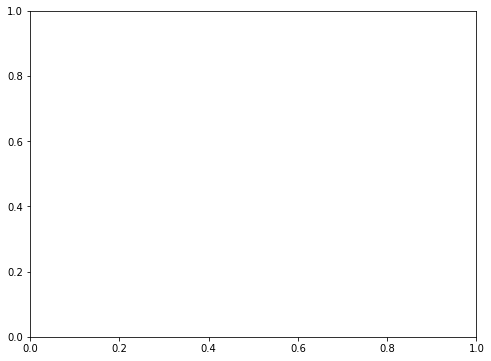

In [1]:
%matplotlib inline
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(8,6))
ax.plot(xls.as_matrix()[:,0], arr[0], "r-")
ax.plot(xls.as_matrix()[:,0], arr[31], "g-")
ax.plot(xls.as_matrix()[:,0], arr[62], "b-")
ax.plot(xls.as_matrix()[:,0], arr[93], "k-")
ax.set_xlim(4000, 500)
ax.set_ylim(0, 0.6)

ValueError: x and y must have same first dimension, but have shapes (2526,) and (100,)

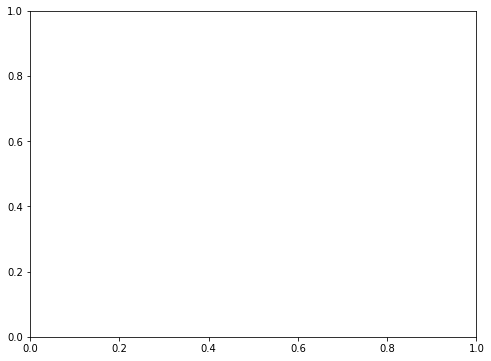

In [75]:
%matplotlib inline
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(8,6))
for i in range(30):
    ax.plot(xls.as_matrix()[:,0], arr[i], "k-")
ax.set_xlim(4000, 500)
ax.set_ylim(0, 1)